# COVID-19 NYT Data Set

In this file, we will download the NYT COVID-19 data set as well as census data estimates for the US population in 2019. We will use both data sets to figure out the number of cases and deaths per 1,000,000 residents of each state on each day. 

Afterwards, we use the latitude and longitude information in the NYT data set to create a map to visualize the spread of COVID during different times of the outbreak.

## Data Setup

In [1]:
import swat   # connect to CAS data sets
import os     # needed to get some variables

# establish a connection
conn = swat.CAS(os.environ.get("CASHOST"), 
                os.environ.get("CASPORT"),
                None,os.environ.get("SAS_VIYA_TOKEN"))

# load the NYT coronavirus data set from CAS
nyt_table = conn.CASTable(caslib = "COVID19", name = "NYT_CORONA_VIRUS")

# export to a SASDataframe
nyt_df = nyt_table.to_frame()

In [2]:
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib aware of Pandas DateTime format
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates # for nicer date formatting

Since the source data set lists data from various counties separately, we first simplify our work by adding up all the cases in each state so that we have only one row of data per state per date for which we have data. We'll write a small function to do this task for us.

In [3]:
def make_state_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter down the columns to the important one. Sum across the counties
    in the state.
    """
    df = df.filter(['Date', 'State','Cases','Deaths', 'STATECODE', 
                    'State_Latitude', 'State_Longitude'])
    short = df.groupby(['Date', 'State', 'STATECODE', 
                    'State_Latitude', 'State_Longitude'],
                        as_index=False).sum()
    return short

# call our function 
df = make_state_summary(nyt_df)

Let's verify the data types to make sure we have everything we need:

In [4]:
df.dtypes

Date                object
State               object
STATECODE           object
State_Latitude     float64
State_Longitude    float64
Cases              float64
Deaths             float64
dtype: object

Note that the date is listed as an "object" type, so we will convert it to a datetime object first.

In [5]:
df.Date = pd.to_datetime(df.Date)
df.dtypes

Date               datetime64[ns]
State                      object
STATECODE                  object
State_Latitude            float64
State_Longitude           float64
Cases                     float64
Deaths                    float64
dtype: object

Since we ultimately want to figure out the case-load and death-toll per million residents of each state, we download a data set from the census bureau which includes estimates for 2019. 

In [6]:
# census data to figure out the population of each state
# can use POPESTIMATE2019 as value for each states population
census_url = "http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#"
pop_set = pd.read_csv(census_url).filter(['REGION', 'DIVISION', 'STATE', 'NAME', 'CENSUS2010POP',
                          'ESTIMATESBASE2010', 'POPESTIMATE2019'])

## Updating our Data Set with the Census Information

Now that we have both data sets in memory, we will calculate the case-load and death-toll for each state and date, with the calculated values added to our data set.

In [7]:
def update_case_load(source : pd.DataFrame, 
                    census : pd.DataFrame) -> pd.DataFrame:
    """
    Function to update a dataframe to include case-load
    and death-toll per million residents using a census
    data set as look-up table for population values.
    """
    for index, row in source.iterrows():
        state = row["State"]
        pop = census[pop_set.NAME==state]["POPESTIMATE2019"].to_numpy()[0]
        cases_per_million = 1e6*row["Cases"]/pop
        deaths_per_million = 1e6*row["Deaths"]/pop
        source.loc[index,"Population"] = pop
        source.loc[index,"CPM"] = cases_per_million
        source.loc[index, "DPM"] = deaths_per_million
    return source

df = update_case_load(df, pop_set)

## Simple Plot Visualition

Let's start with a few simple visualizations to compare different states. To make it easier, we create a short function that gets the necessary data out, followed by a short function to do the plotting with the output data set.

In [8]:
def state_sets(df : pd.DataFrame, States: List) -> Dict:
    """
    Given the master-list of data, select subsets based on state names.
    """
    out_dict = {state : df[df.STATECODE==state] for state in States }
    return out_dict

def line_plot_states(states_of_interest : Dict,
                    min_date : str = "2020-03-01"):
    fig, ax = plt.subplots(figsize=(10,5.625))
    # add the relevant plots
    for key, data in states_of_interest.items():
        subdata = data[data.Date>=pd.to_datetime(min_date)]
        ax.plot(subdata.Date, subdata.CPM, label=key)
    ax.legend()

    # make the axis pretty
    fig.autofmt_xdate()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.set_ylabel('Cases per Million')


    plt.show(fig)

Now all we need to do is call our function and then iterate through the result to plot several different states.

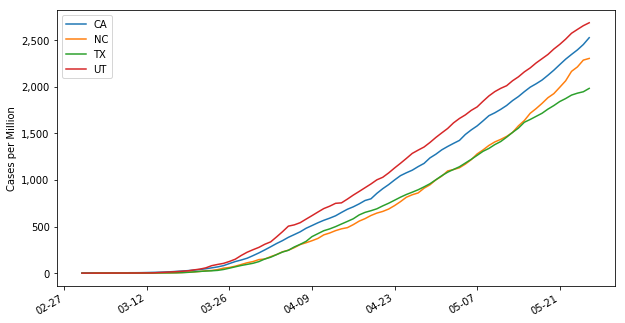

In [9]:
state_list = sorted(["CA", "TX", "NC", "UT"])
states_of_interest = state_sets(df, state_list)
line_plot_states(states_of_interest)

## Making a Heat Map

It can be hard to keep track of all states and all dates with a line chart. Let's try using a heat map instead. We'll bring our pandas Dataframe back to SAS using the SASPy package. We'll begin by importing the SASPy package and establishing a connection to SAS.

In [10]:
import saspy  # package to get access to SAS

sas_session = saspy.SASsession()

Using SAS Config named: iomlinux
SAS Connection established. Subprocess id is 92532



With the connection established, we will use the `df2sd` function to move our dataframe over to our SAS working library.

In [11]:
sas_session.df2sd(df, table="full_data")

Libref  = WORK
Table   = full_data
Dsopts  = {}
Results = Pandas

With the table available in our working library, we will use the `%%SAS` magic keyword to run the necessary SAS code to generate our heatmap.


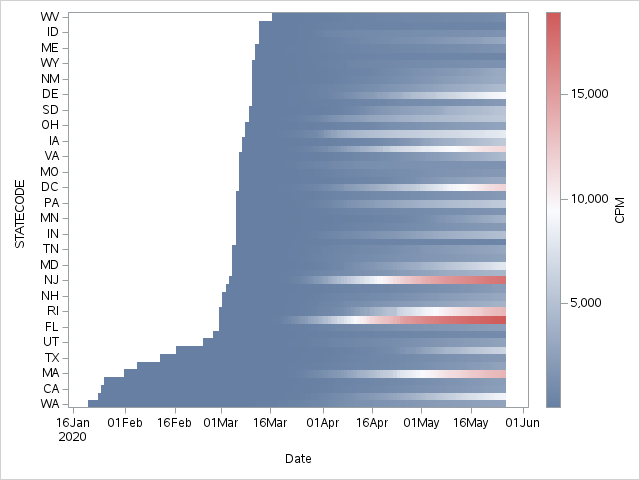

In [27]:
%%SAS sas_session

proc sgplot data=work.full_data;
    format CPM COMMA12.;
	heatmapparam x=Date y=STATECODE colorresponse=CPM / name='HeatMap'  ;
	gradlegend 'HeatMap';
run;

Note that the states on the y-axis are sorted by the amount of data we have, with ushaving the most data points for states like Washington and California, and the fewest for states like West Virgina and Idaho. For comparison, we can make the same plot but with raw case data.


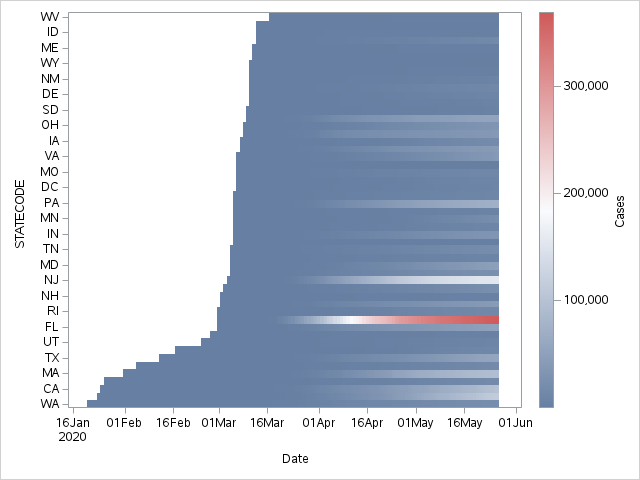

In [24]:
%%SAS sas_session

proc sgplot data=work.full_data;
    format Cases COMMA10.;
    heatmapparam x=Date y=STATECODE colorresponse=Cases / name='HeatMap' discretey ;
    gradlegend 'HeatMap';
run;

## Making the Map

Making maps and plotting over them is hard. Luckily, SAS has a special procedure for this available. We will now collect the necessary information we want from our data set and export them to SAS for plotting. We'll pick data corresponding to a single date, say May 20, and upload the data set to SAS.

In [15]:
dates_of_interest = ["2020-05-20"]
sub_df = df[df.Date.isin(dates_of_interest)]

sas_session.df2sd(sub_df, table="map_data")

Libref  = WORK
Table   = map_data
Dsopts  = {}
Results = Pandas

The `proc sgmamp` procedure in base SAS can help us make the type of graphic we are looking for. [See here](https://blogs.sas.com/content/graphicallyspeaking/2017/12/14/sgmap-now-in-base-sas/). [Documentation](https://go.documentation.sas.com/?docsetId=grmapref&docsetTarget=n12i6frnyv35f6n16p7bo3u6hy2a.htm&docsetVersion=9.4_01&locale=en). We'll now make a bubble plot that gives us a feeling for how the data is distributed.


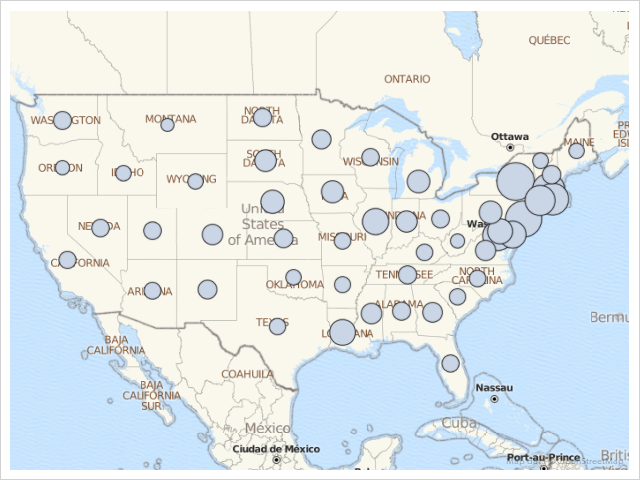

In [16]:
%%SAS sas_session

proc sgmap plotdata=map_data;
     openstreetmap;
    where STATECODE not in ('AK','HI');
     bubble x=State_Longitude y=State_Latitude size=CPM;
run;

It would be nice if we could get a choropleth map of the situation. Well, `gmap` to the rescue. We will use the `levels=5` statement to use quintile binning.

In [22]:
%%SAS sas_session

proc gmap data=work.map_data map=mapsgfk.us all;
    id STATECODE;
    format CPM COMMA10.;
    choro CPM / levels=5;
run;

Notice that the ranges aren't the same size. We can use the `midpoints` statement to force a different selection of levels. For example, by using `midpoints=old`, we can use the Nelder algorithm to determine the appropriate ranges.

In [23]:
%%SAS sas_session

proc gmap data=work.map_data map=mapsgfk.us all;
    id STATECODE;
    format CPM COMMA10.;
    choro CPM / midpoints=old;
run;

This highlights the uneven distribution of COVID-19 across the United States.

## Export Data

In case we want to work with these data sets later, let's export what we have both to CSV files and to SAS datasets that are saved in VFL and will be accessible from SAS Studio.

In [20]:
#the csv save

df.to_csv("full_data.csv")
sub_df.to_csv("map_data.csv")

In [21]:
%%SAS sas_session

OPTIONS DLCREATEDIR;
LIBNAME c19 "/shared/home/&SYSUSERID/mycovid/";

data c19.full_data;
    set work.full_data;
run;

data c19.map_data;
    set work.map_data;
run;

Now you can go explore the data outside of this notebook as well!